# Howto

Original implementation: https://github.com/sveinn-steinarsson/flot-downsample

Downloaded CSV from lttp-numpy repo at https://git.sr.ht/~javiljoen/lttb-numpy/tree/master/item/tests/timeseries.csv (added to this repo as well)


This repo by Charl P. Botha https://charlbotha.com/

## Quickstart

Setup virtual environment with required packages:

```shell
poetry env use 3.11
poetry install --no-root
```

Open this notebook with vscode or jupyter, then go through the cells, or skip straight to the last cell [Bench all of the implementations](#bench-all-of-the-implementations).


## Load data and init

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("timeseries.csv")
tseries = df.values

x = tseries[:,0]
y = tseries[:,1]

# Make tseries C-contiguous
tseries = np.copy(df.values, order='C')

THRESHOLD = 250

tseries.shape

(5000, 2)

## lttbc: C + numpy version by dgoeries

See https://github.com/dgoeries/lttbc

Super neat numpy-API implementation in C

<Axes: >

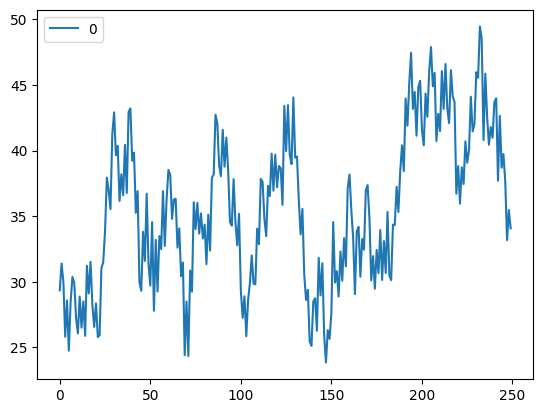

In [10]:
import lttbc

nx, ny = lttbc.downsample(x, y, THRESHOLD)

pd.DataFrame(ny).plot()

In [3]:
%%timeit
down_x, down_y = lttbc.downsample(x, y, THRESHOLD)

8.79 µs ± 85.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## lttb-numpy by javiljoen

See https://git.sr.ht/~javiljoen/lttb-numpy

<Axes: >

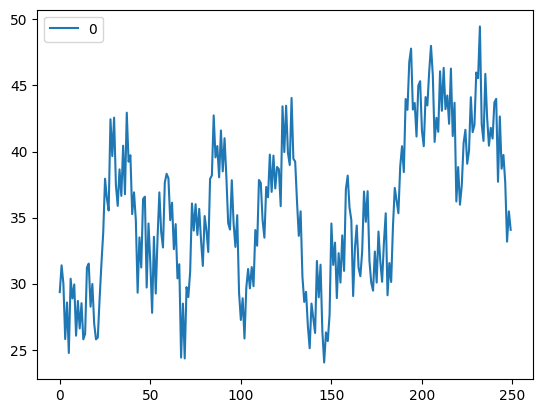

In [3]:
import lttb

# No input validation:
small_data = lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

pd.DataFrame(small_data[:,1]).plot()

In [5]:
%%timeit
lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

2.98 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## lttb-numpy by javiljoen — slightly modified and Pythran compiled

See https://github.com/serge-sans-paille/pythran

In [ ]:
%%bash
pythran lttb_pt.py

<Axes: >

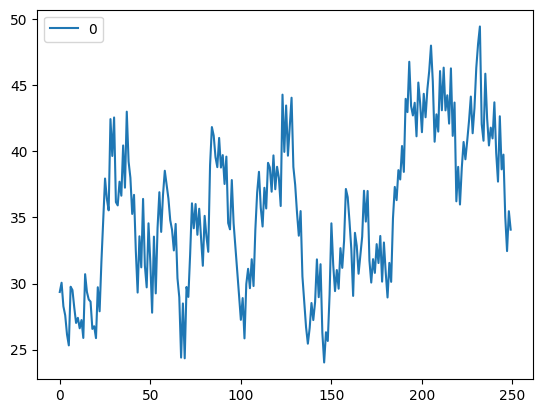

In [21]:
import lttb_pt

# No input validation:
small_data = lttb_pt.downsample(tseries, THRESHOLD)

pd.DataFrame(small_data[:,1]).plot()

In [4]:
%%timeit
lttb_pt.downsample(tseries, n_out=THRESHOLD)

3.68 ms ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## lttb-numpy by javiljoen -- modified for numba jit compilation

<Axes: >

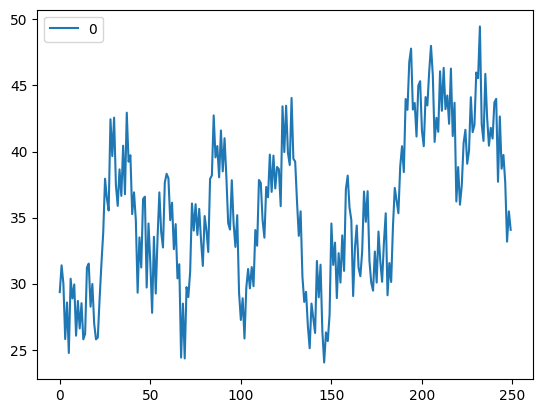

In [2]:
from lttb_numba import numba_downsample
numba_data = numba_downsample(tseries, n_out=THRESHOLD)
pd.DataFrame(numba_data[:,1]).plot()

In [19]:
%timeit numba_downsample(tseries, n_out=THRESHOLD)

115 µs ± 284 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## pylttb by dexter 2206

<Axes: >

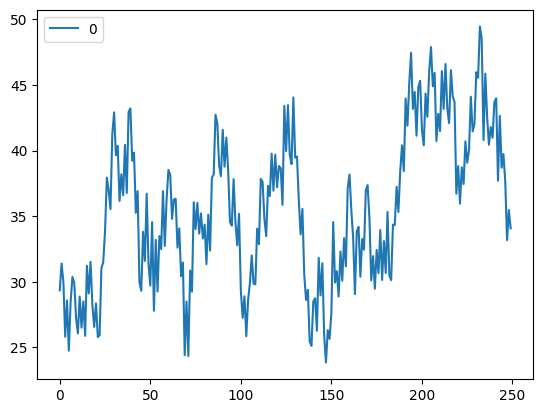

In [4]:
# https://github.com/dexter2206/pylttb
import pylttb

down_x, down_y = pylttb.lttb(x, y, THRESHOLD)

pd.DataFrame(down_y).plot()

In [10]:
%%timeit
pylttb.lttb(x, y, THRESHOLD)

3 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Working cython by cpbotha

About 10 to 15% slower than lttbc, but still quite fast.

In [6]:
# we use pyximport here for experimentation

import pyximport
pyximport.install()
import lttbcy

In [7]:
print(lttbcy)

<module 'lttbcy' from '/home/cpbotha/.pyxbld/lib.linux-x86_64-cpython-311/lttbcy.cpython-311-x86_64-linux-gnu.so'>


In [13]:
%%timeit
lttbcy.downsample(x, y, THRESHOLD)

10.3 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<Axes: >

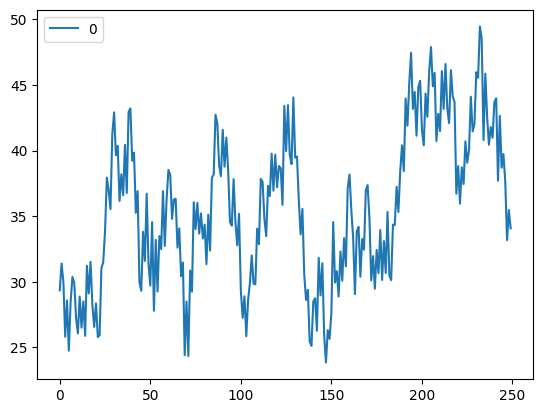

In [8]:
import pandas as pd
down_x, down_y = lttbcy.downsample(x,y,THRESHOLD)
pd.DataFrame(down_y).plot()

<Axes: >

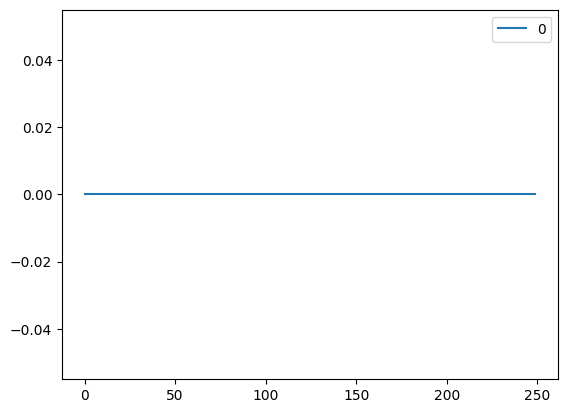

In [12]:
# check that results are identical to lttbc
pd.DataFrame(down_y - ny).plot()

## Use cython version to make comparative plots


<module 'lttbcy' from '/Users/charlbotha/Library/CloudStorage/OneDrive-Personal/code/mine/sandbox/lttb-bench/lttbcy.cpython-311-darwin.so'>


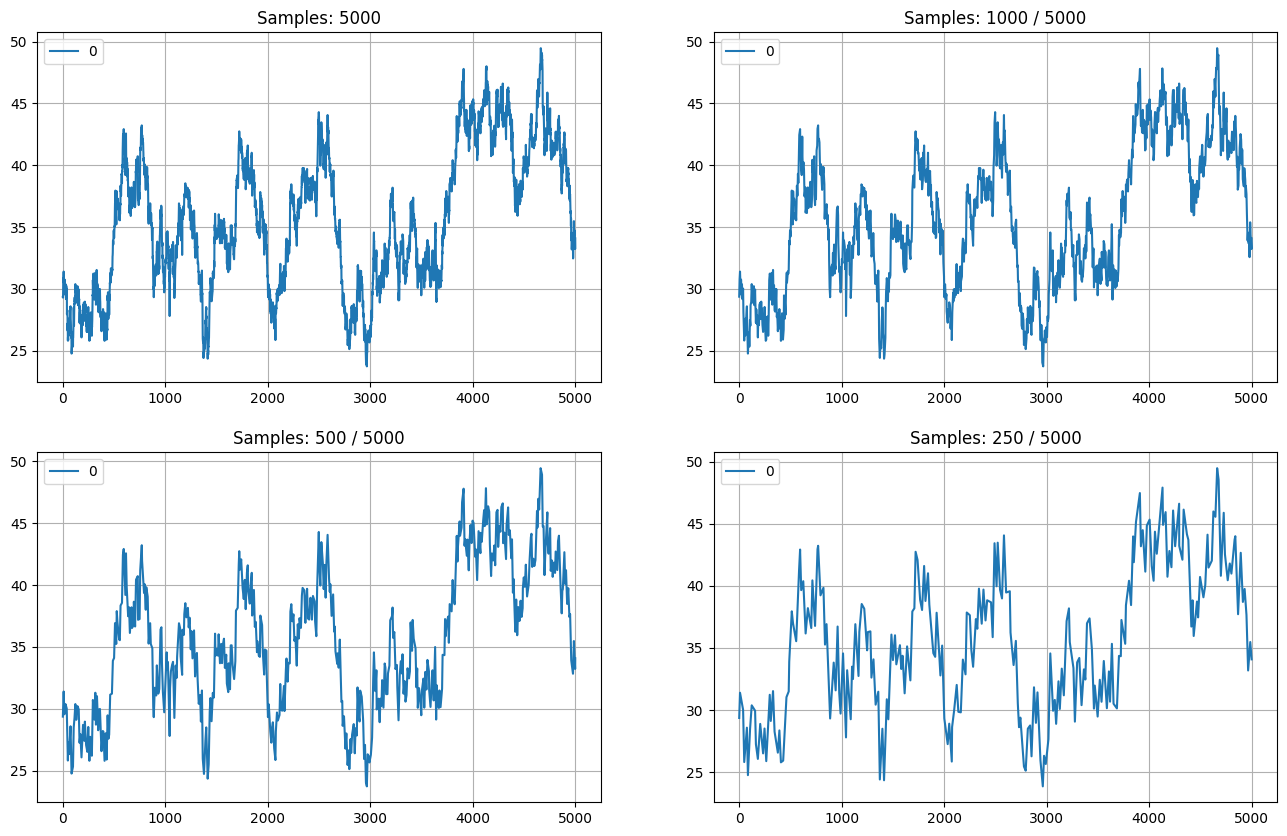

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
# first do: python setup.py build_ext --inplace
import lttbcy
# make sure this is the built version, and not the pyximported one
print(lttbcy)

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

pd.DataFrame(y, index=x).plot(ax=axs[0,0], title=f"Samples: {len(x)}").grid()
ax_idx = 1
for thresh in [1000, 500, 250]:
    down_x, down_y = lttbcy.downsample(x, y, thresh)
    pd.DataFrame(down_y, index=down_x).plot(ax=axs[ax_idx // 2, ax_idx % 2], title=f"Samples: {thresh} / {len(x)}").grid()
    ax_idx += 1

## Bench all of the implementations

In [19]:
# prepare our test data
import platform
import sys

import cpuinfo
import numpy as np
import pandas as pd

df = pd.read_csv('timeseries.csv')
tseries = df.values

x = tseries[:,0]
y = tseries[:,1]

# Make tseries contiguous
tseries = np.copy(tseries, order='C')

THRESHOLD = 250

print(f"Python {sys.version} on {sys.platform} on {platform.machine()} ({cpuinfo.get_cpu_info()['brand_raw']})")

print("lttbc")
import lttbc

%timeit lttbc.downsample(x, y, THRESHOLD)

print("\nlttb-numpy")
import lttb

%timeit lttb.downsample(tseries, n_out=THRESHOLD, validators=[])

print("\npylttb")
import pylttb

%timeit pylttb.lttb(x, y, THRESHOLD)

print("\nlttb-cython")
import pyximport

pyximport.install()
import lttbcy

%timeit lttbcy.downsample(x, y, THRESHOLD)

print("\nlttb-pythran")
import os

# on Linux and macOS, this build step can be flaky, and couse the kernel to crash
# restart the kernel, and then execute just this cell
# On Windoms, rather build this in the "x64 Native Tools Command Prompt for VS", with clang-cl.exe installed
os.system("pythran lttb_pt.py")
import lttb_pt

%timeit lttb_pt.downsample(tseries, THRESHOLD)

print("\nlttb-numba")
from lttb_numba import numba_downsample

# warm up first
_ = numba_downsample(tseries, n_out=THRESHOLD)
%timeit numba_downsample(tseries, n_out=THRESHOLD)

Python 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)] on darwin on arm64 (Apple M1 Max)
lttbc
19.9 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

lttb-numpy
2.25 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

pylttb
2.4 ms ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

lttb-cython
21.3 µs ± 413 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

lttb-pythran
16.7 µs ± 27.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

lttb-numba
178 µs ± 583 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
